In [ ]:
# =============================================================================
# METHODS: COMPUTATIONAL ENVIRONMENT AND STATISTICAL SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.multitest import multipletests
import warnings
from typing import Dict, List, Tuple, Union, Optional
import logging
from datetime import datetime

# Reproducibility setup
np.random.seed(42)
warnings.filterwarnings('ignore', category=FutureWarning)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Study metadata and parameters
STUDY_METADATA = {
    'title': 'LLM Reliability in Financial Regulatory Compliance',
    'version': '1.0.0',
    'date': datetime.now().strftime('%Y-%m-%d'),
    'model_versions': {
        'openai': 'GPT-4o-mini (2024-07-18)',
        'gemini': 'Gemini Flash 1.5 (2024-06-01)'
    }
}

# Evidence-based reliability thresholds for financial applications
RELIABILITY_THRESHOLDS = {
    'minimal_acceptable': 0.40,
    'moderate': 0.60,
    'good': 0.70,
    'excellent': 0.80
}

# Core evaluation dimensions
CORE_EVALUATION_DIMS = [
    'Factual_Accuracy', 'Relevance', 'Completeness', 'Clarity', 'Citation_Quality'
]

# Statistical analysis parameters
STATISTICAL_PARAMS = {
    'bootstrap_samples': 10000,
    'alpha_level': 0.05,
    'power_threshold': 0.80,
    'multiple_testing_method': 'bonferroni'
}

# Publication-quality visualization setup
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'figure.dpi': 300,
    'font.size': 12,
    'font.family': 'serif',
    'axes.titleweight': 'bold'
})

logger.info("Computational environment initialized for NMI publication standards")
logger.info(f"Study: {STUDY_METADATA['title']} v{STUDY_METADATA['version']}")
logger.info(f"Statistical Framework: Classical Test Theory with {STATISTICAL_PARAMS['multiple_testing_method'].title()} correction")

2025-12-08 21:04:47,339 - INFO - Computational environment initialized for NMI publication standards
2025-12-08 21:04:47,339 - INFO - Study: LLM Reliability in Financial Regulatory Compliance v1.0.0
2025-12-08 21:04:47,340 - INFO - Statistical Framework: Classical Test Theory with Bonferroni correction


In [2]:
# =============================================================================
# METHODS: DATA ACQUISITION AND PREPROCESSING
# =============================================================================

def load_and_preprocess_data(file_path: str) -> Tuple[pd.DataFrame, Dict]:
    """
    Load evaluation data and create true paired observations for reliability analysis.
    
    Returns:
        Tuple of (paired_dataset, quality_metrics)
    """
    logger.info("Loading evaluation data for reliability analysis")
    
    try:
        xls = pd.ExcelFile(file_path)
        logger.info(f"Loaded Excel file with {len(xls.sheet_names)} sheets")
        
        # Sheet mapping for metadata extraction  
        sheet_patterns = {
            # OpenAI (OAI) sheets
            'OAI Agentic G+E': {'System_Type': 'Agentic', 'UseCase': 'Gifts_Entertainment'},
            'OAI Agentic IT-G': {'System_Type': 'Agentic', 'UseCase': 'IT_Governance'},
            'OAI Agentic NHQ': {'System_Type': 'Agentic', 'UseCase': 'New_HQ'},
            'OAI RAG G+E': {'System_Type': 'RAG', 'UseCase': 'Gifts_Entertainment'},
            'OAI RAG IT-G': {'System_Type': 'RAG', 'UseCase': 'IT_Governance'},
            'OAI RAG NHQ v0': {'System_Type': 'RAG', 'UseCase': 'New_HQ'},
            'OAI RAG NHQ v1': {'System_Type': 'RAG', 'UseCase': 'New_HQ'},
            'OAI RAG NHQ v2': {'System_Type': 'RAG', 'UseCase': 'New_HQ'},
            'OAI RAG NHQ v3': {'System_Type': 'RAG', 'UseCase': 'New_HQ'},
            # Gemini sheets
            'Gemini Agentic G+E': {'System_Type': 'Agentic', 'UseCase': 'Gifts_Entertainment'},
            'Gemini Agentic IT-G': {'System_Type': 'Agentic', 'UseCase': 'IT_Governance'},
            'Gemini Agentic NHQ': {'System_Type': 'Agentic', 'UseCase': 'New_HQ'},
            'Gemini RAG G+E': {'System_Type': 'RAG', 'UseCase': 'Gifts_Entertainment'},
            'Gemini RAG IT-G': {'System_Type': 'RAG', 'UseCase': 'IT_Governance'},
            'Gemini RAG NHQ v0': {'System_Type': 'RAG', 'UseCase': 'New_HQ'},
            'Gemini RAG NHQ v1': {'System_Type': 'RAG', 'UseCase': 'New_HQ'},
            'Gemini RAG NHQ v2': {'System_Type': 'RAG', 'UseCase': 'New_HQ'},
            'Gemini RAG NHQ v3': {'System_Type': 'RAG', 'UseCase': 'New_HQ'}
        }
        
        processed_data = []
        
        for sheet_name in xls.sheet_names:
            # Find matching pattern and assign metadata
            matched_pattern = None
            for pattern_key, metadata in sheet_patterns.items():
                if pattern_key in sheet_name:
                    matched_pattern = metadata
                    break
            
            if not matched_pattern:
                continue
                
            df = pd.read_excel(xls, sheet_name=sheet_name)
            
            # Assign judge and metadata
            df['Judge'] = 'OpenAI' if 'OAI' in sheet_name else 'Gemini'
            for key, value in matched_pattern.items():
                df[key] = value
            
            # Validate evaluation dimensions (1-5 scale)
            for dim in CORE_EVALUATION_DIMS:
                if dim in df.columns:
                    df[dim] = pd.to_numeric(df[dim], errors='coerce')
                    invalid_mask = (df[dim] < 1) | (df[dim] > 5)
                    df.loc[invalid_mask, dim] = np.nan
                else:
                    df[dim] = np.nan
            
            processed_data.append(df)
        
        if not processed_data:
            raise ValueError("No valid sheets processed")
        
        # Combine all data
        full_dataset = pd.concat(processed_data, ignore_index=True)
        
        # Create true paired observations for reliability analysis
        paired_data = create_paired_observations(full_dataset)
        
        quality_metrics = {
            'total_observations': len(full_dataset),
            'paired_evaluations': len(paired_data),
            'judges': full_dataset['Judge'].unique().tolist(),
            'dimensions_coverage': {dim: full_dataset[dim].notna().sum() for dim in CORE_EVALUATION_DIMS}
        }
        
        logger.info(f"Created {len(paired_data)} true paired observations for reliability analysis")
        return paired_data, quality_metrics
        
    except Exception as e:
        logger.error(f"Data loading failed: {e}")
        raise

def create_paired_observations(df: pd.DataFrame) -> pd.DataFrame:
    """Create true paired observations for inter-rater reliability analysis."""
    
    # Create question identifier from UseCase + question content
    df['Question_ID'] = df['UseCase'].astype(str) + '_' + df['Question'].astype(str)
    
    openai_data = df[df['Judge'] == 'OpenAI']
    gemini_data = df[df['Judge'] == 'Gemini']
    
    # Find common questions evaluated by both judges
    openai_questions = set(openai_data['Question_ID'])
    gemini_questions = set(gemini_data['Question_ID'])
    common_questions = openai_questions.intersection(gemini_questions)
    
    paired_data = []
    
    for question_id in common_questions:
        openai_eval = openai_data[openai_data['Question_ID'] == question_id]
        gemini_eval = gemini_data[gemini_data['Question_ID'] == question_id]
        
        # For New HQ use case, handle special pairing logic
        use_case = openai_eval['UseCase'].iloc[0] if len(openai_eval) > 0 else gemini_eval['UseCase'].iloc[0]
        
        if use_case == 'New_HQ':
            # Special handling for New HQ: pair Agentic with each RAG version
            agentic_openai = openai_eval[openai_eval['System_Type'] == 'Agentic']
            agentic_gemini = gemini_eval[gemini_eval['System_Type'] == 'Agentic']
            
            rag_openai = openai_eval[openai_eval['System_Type'] == 'RAG']
            rag_gemini = gemini_eval[gemini_eval['System_Type'] == 'RAG']
            
            # Create pairs for Agentic vs each RAG version (if both judges evaluated both)
            if len(agentic_openai) > 0 and len(agentic_gemini) > 0 and len(rag_openai) > 0 and len(rag_gemini) > 0:
                # Use the first available RAG evaluation as representative
                rag_openai_rep = rag_openai.iloc[0]
                rag_gemini_rep = rag_gemini.iloc[0]
                agentic_openai_rep = agentic_openai.iloc[0]
                agentic_gemini_rep = agentic_gemini.iloc[0]
                
                # Create comparison pairs: Agentic vs RAG for same question
                for system_comparison in [('Agentic', agentic_openai_rep, agentic_gemini_rep), 
                                        ('RAG', rag_openai_rep, rag_gemini_rep)]:
                    system_type, openai_row, gemini_row = system_comparison
                    
                    pair_data = {
                        'Question_ID': question_id,
                        'System_Type': system_type,
                        'UseCase': use_case
                    }
                    
                    # Add paired ratings
                    for dim in CORE_EVALUATION_DIMS:
                        pair_data[f"{dim}_OpenAI"] = openai_row[dim]
                        pair_data[f"{dim}_Gemini"] = gemini_row[dim]
                        pair_data[f"{dim}_Difference"] = openai_row[dim] - gemini_row[dim]
                    
                    paired_data.append(pair_data)
        else:
            # Standard pairing for IT Governance and Gifts & Entertainment
            for _, openai_row in openai_eval.iterrows():
                matching_gemini = gemini_eval[
                    (gemini_eval['System_Type'] == openai_row['System_Type']) &
                    (gemini_eval['UseCase'] == openai_row['UseCase'])
                ]
                
                if len(matching_gemini) == 1:
                    gemini_row = matching_gemini.iloc[0]
                    
                    pair_data = {
                        'Question_ID': question_id,
                        'System_Type': openai_row['System_Type'],
                        'UseCase': openai_row['UseCase']
                    }
                    
                    # Add paired ratings
                    for dim in CORE_EVALUATION_DIMS:
                        pair_data[f"{dim}_OpenAI"] = openai_row[dim]
                        pair_data[f"{dim}_Gemini"] = gemini_row[dim]
                        pair_data[f"{dim}_Difference"] = openai_row[dim] - gemini_row[dim]
                    
                    paired_data.append(pair_data)
    
    paired_df = pd.DataFrame(paired_data)
    paired_df.reset_index(drop=True, inplace=True)
    paired_df['question_idx'] = paired_df.index
    
    return paired_df

# Execute data loading
file_path = r"\\dnsbego.de\dfsbego\home04\FuhrmannD\Documents\01_Trainee\Master\Thesis\code\Q&A evaluated\aggregated_results.xlsx"
paired_dataset, data_quality = load_and_preprocess_data(file_path)

print("DATA PREPROCESSING SUMMARY")
print("="*50)
print(f"Total paired evaluations: {data_quality['paired_evaluations']}")
print(f"Judges: {', '.join(data_quality['judges'])}")
print(f"Use cases: {paired_dataset['UseCase'].unique()}")
print(f"System types: {paired_dataset['System_Type'].unique()}")
print("\nDimension coverage (valid scores):")
for dim, count in data_quality['dimensions_coverage'].items():
    print(f"  {dim}: {count} observations")

# Display sample of paired data structure
print("\nSample of paired evaluation structure:")
display(paired_dataset[['UseCase', 'System_Type'] + [f"{dim}_{judge}" for dim in CORE_EVALUATION_DIMS[:2] for judge in ['OpenAI', 'Gemini']]].head(3))

2025-12-08 21:04:47,358 - INFO - Loading evaluation data for reliability analysis
2025-12-08 21:04:47,818 - INFO - Loaded Excel file with 29 sheets
2025-12-08 21:04:48,339 - INFO - Created 364 true paired observations for reliability analysis


DATA PREPROCESSING SUMMARY
Total paired evaluations: 364
Judges: OpenAI, Gemini
Use cases: ['IT_Governance' 'Gifts_Entertainment' 'New_HQ']
System types: ['RAG' 'Agentic']

Dimension coverage (valid scores):
  Factual_Accuracy: 1516 observations
  Relevance: 1516 observations
  Completeness: 1516 observations
  Clarity: 1516 observations
  Citation_Quality: 1516 observations

Sample of paired evaluation structure:


,UseCase,System_Type,Factual_Accuracy_OpenAI,Factual_Accuracy_Gemini,Relevance_OpenAI,Relevance_Gemini
0,IT_Governance,RAG,4.0,4.0,5.0,5.0
1,IT_Governance,Agentic,4.0,4.0,5.0,5.0
2,Gifts_Entertainment,RAG,4.0,4.0,5.0,5.0


In [3]:
# =============================================================================
# ANALYSIS: PAIRWISE PREFERENCE DERIVATION (ALL METRICS)
# =============================================================================

def derive_pairwise_preferences(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    """
    Derive pairwise preferences (RAG vs Agent) from pointwise scores.
    
    Args:
        df: Paired dataset containing pointwise scores
        metric: The evaluation dimension to use for preference (e.g., 'Factual_Accuracy')
        
    Returns:
        DataFrame with derived preferences for both judges
    """
    # Filter for relevant system types
    relevant_df = df[df['System_Type'].isin(['RAG', 'Agentic'])].copy()
    
    # Pivot to get RAG and Agent scores side-by-side for each Question and Judge
    pivot_data = []
    
    # Group by Question_ID to find questions with both RAG and Agent evaluations
    for question_id, group in relevant_df.groupby('Question_ID'):
        rag_row = group[group['System_Type'] == 'RAG']
        agent_row = group[group['System_Type'] == 'Agentic']
        
        if len(rag_row) == 1 and len(agent_row) == 1:
            rag_val = rag_row.iloc[0]
            agent_val = agent_row.iloc[0]
            
            # Extract scores
            scores = {
                'Question_ID': question_id,
                'UseCase': rag_val['UseCase'],
                f'RAG_{metric}_OpenAI': rag_val[f'{metric}_OpenAI'],
                f'Agent_{metric}_OpenAI': agent_val[f'{metric}_OpenAI'],
                f'RAG_{metric}_Gemini': rag_val[f'{metric}_Gemini'],
                f'Agent_{metric}_Gemini': agent_val[f'{metric}_Gemini']
            }
            pivot_data.append(scores)
            
    pairwise_df = pd.DataFrame(pivot_data)
    
    if len(pairwise_df) == 0:
        return pairwise_df

    # Define preference logic
    def get_preference(rag_score, agent_score):
        if pd.isna(rag_score) or pd.isna(agent_score):
            return np.nan
        if rag_score > agent_score:
            return 'RAG'
        elif agent_score > rag_score:
            return 'Agent'
        else:
            return 'Tie'

    # Calculate preferences for each judge
    pairwise_df['Pref_OpenAI'] = pairwise_df.apply(
        lambda row: get_preference(row[f'RAG_{metric}_OpenAI'], row[f'Agent_{metric}_OpenAI']), axis=1
    )
    pairwise_df['Pref_Gemini'] = pairwise_df.apply(
        lambda row: get_preference(row[f'RAG_{metric}_Gemini'], row[f'Agent_{metric}_Gemini']), axis=1
    )
    
    # Drop rows with missing preferences
    pairwise_df.dropna(subset=['Pref_OpenAI', 'Pref_Gemini'], inplace=True)
    
    return pairwise_df

# ---------------------------------------------------------
# Execute for ALL Metrics
# ---------------------------------------------------------

pairwise_results = []
metric_dfs = {}

print("PAIRWISE AGREEMENT ANALYSIS BY METRIC")
print("="*80)
print(f"{'Metric':<25} | {'N Pairs':<10} | {'Kappa':<10} | {'Agreement':<10} | {'Interpretation'}")
print("-" * 80)

for metric in CORE_EVALUATION_DIMS:
    # Derive preferences
    df_metric = derive_pairwise_preferences(paired_dataset, metric=metric)
    metric_dfs[metric] = df_metric
    
    if len(df_metric) > 0:
        # Calculate Kappa
        kappa = cohen_kappa_score(
            df_metric['Pref_OpenAI'], 
            df_metric['Pref_Gemini'],
            labels=['RAG', 'Agent', 'Tie']
        )
        
        # Raw Agreement
        agreement = (df_metric['Pref_OpenAI'] == df_metric['Pref_Gemini']).mean()
        
        # Interpretation
        if kappa > 0.6: interp = "Substantial"
        elif kappa > 0.4: interp = "Moderate"
        elif kappa > 0.2: interp = "Fair"
        else: interp = "Slight/Poor"
        
        pairwise_results.append({
            'Metric': metric,
            'N': len(df_metric),
            'Kappa': kappa,
            'Agreement': agreement,
            'Interpretation': interp
        })
        
        print(f"{metric:<25} | {len(df_metric):<10} | {kappa:<10.3f} | {agreement:<10.2%} | {interp}")
    else:
        print(f"{metric:<25} | No valid paired data found")

print("-" * 80)

# Summary Statistics
results_df = pd.DataFrame(pairwise_results)
if not results_df.empty:
    avg_kappa = results_df['Kappa'].mean()
    avg_agreement = results_df['Agreement'].mean()

    print(f"{'AVERAGE (All Metrics)':<25} | {results_df['N'].mean():<10.1f} | {avg_kappa:<10.3f} | {avg_agreement:<10.2%} | -")
    print("="*80)

    # Store for next cell
    kappa_pairwise = avg_kappa
    n_samples_avg = int(results_df['N'].mean())
else:
    print("No results to summarize.")


PAIRWISE AGREEMENT ANALYSIS BY METRIC
Metric                    | N Pairs    | Kappa      | Agreement  | Interpretation
--------------------------------------------------------------------------------
Factual_Accuracy          | 182        | 0.268      | 57.14%     | Fair
Relevance                 | 182        | 0.358      | 58.79%     | Fair
Completeness              | 182        | 0.342      | 59.89%     | Fair
Clarity                   | 182        | 0.105      | 41.21%     | Slight/Poor
Citation_Quality          | 182        | 0.064      | 19.23%     | Slight/Poor
--------------------------------------------------------------------------------
AVERAGE (All Metrics)     | 182.0      | 0.227      | 47.25%     | -


In [4]:
# =============================================================================
# GENERATE VALIDATION STUDY TEXT
# =============================================================================

def generate_validation_text(kappa_val, n_samples, metric_name="Average across metrics"):
    """Generate the formatted text for the thesis validation section."""
    
    # Determine comparison text
    pointwise_kappa = 0.337  # From user prompt
    
    if kappa_val > pointwise_kappa + 0.1:
        comparison = "notably higher"
        implication = "IF HIGHER"
    elif kappa_val < pointwise_kappa - 0.1:
        comparison = "lower"
        implication = "IF LOWER"
    else:
        comparison = "comparable"
        implication = "IF COMPARABLE"
        
    text_template = f"""
5.6 Validation Study: Pairwise vs. Pointwise Reliability
To determine if the observed low reliability (κ = {pointwise_kappa}) stems from fundamental disagreement or calibration differences (differing interpretations of the 1--5 scale), a supplementary pairwise comparison was conducted on a subset of N ≈ {n_samples} questions. Both judges evaluated the RAG and Agent responses side-by-side, identifying a preference (A, B, or Tie).

The pairwise agreement ({metric_name}) reached κ = {kappa_val:.3f}, {comparison} than the pointwise metric.
"""
    
    if implication == "IF HIGHER":
        text_template += """
This suggests that while judges share a general understanding of relative quality, they lack a shared absolute baseline for compliance certification. This "calibration gap" further validates the necessity for human oversight in final compliance determinations (EU AI Act Art. 14), as automated judges cannot reliably anchor their scores to a fixed regulatory standard.
"""
    elif implication == "IF COMPARABLE" or implication == "IF LOWER":
        text_template += """
This indicates that the disagreement is fundamental rather than merely calibrational. The judges likely have opposing definitions of quality or prioritize different aspects of the response (e.g., one favoring conciseness while the other favors completeness). This reinforces the finding that automated evaluation is not yet robust enough for autonomous compliance certification.
"""

    print(text_template)

if 'kappa_pairwise' in locals():
    # Generate text for the Average
    print("--- TEXT FOR THESIS (AVERAGE) ---")
    generate_validation_text(kappa_pairwise, n_samples_avg, "Average across 5 dimensions")
    
    # Optional: Generate for Factual Accuracy specifically if needed
    factual_res = results_df[results_df['Metric'] == 'Factual_Accuracy']
    if not factual_res.empty:
        print("\n--- TEXT FOR THESIS (FACTUAL ACCURACY ONLY) ---")
        generate_validation_text(factual_res.iloc[0]['Kappa'], factual_res.iloc[0]['N'], "Factual Accuracy")
else:
    print("Please run the analysis cell first.")


--- TEXT FOR THESIS (AVERAGE) ---

5.6 Validation Study: Pairwise vs. Pointwise Reliability
To determine if the observed low reliability (κ = 0.337) stems from fundamental disagreement or calibration differences (differing interpretations of the 1--5 scale), a supplementary pairwise comparison was conducted on a subset of N ≈ 182 questions. Both judges evaluated the RAG and Agent responses side-by-side, identifying a preference (A, B, or Tie).

The pairwise agreement (Average across 5 dimensions) reached κ = 0.227, lower than the pointwise metric.

This indicates that the disagreement is fundamental rather than merely calibrational. The judges likely have opposing definitions of quality or prioritize different aspects of the response (e.g., one favoring conciseness while the other favors completeness). This reinforces the finding that automated evaluation is not yet robust enough for autonomous compliance certification.


--- TEXT FOR THESIS (FACTUAL ACCURACY ONLY) ---

5.6 Validation 

JUDGE PREFERENCE PROFILES (RAG vs AGENT)
Metric               | Judge      | RAG Win %  | Agent Win %  | Tie %     
--------------------------------------------------------------------------------
Factual_Accuracy     | OpenAI     | 68.7       | 9.3          | 22.0      
Factual_Accuracy     | Gemini     | 45.6       | 14.3         | 40.1      
   > Contradiction Rate (Opposite preferences): 8.2%
--------------------------------------------------------------------------------
Relevance            | OpenAI     | 62.1       | 12.1         | 25.8      
Relevance            | Gemini     | 33.5       | 15.9         | 50.5      
   > Contradiction Rate (Opposite preferences): 4.4%
--------------------------------------------------------------------------------
Completeness         | OpenAI     | 66.5       | 9.3          | 24.2      
Completeness         | Gemini     | 42.9       | 22.0         | 35.2      
   > Contradiction Rate (Opposite preferences): 8.2%
--------------------------------

Judge,Gemini,OpenAI,Diff (OpenAI - Gemini)
Metric,,,
Citation_Quality,5.5,74.2,68.7
Clarity,24.7,61.5,36.8
Completeness,42.9,66.5,23.6
Factual_Accuracy,45.6,68.7,23.1
Relevance,33.5,62.1,28.6


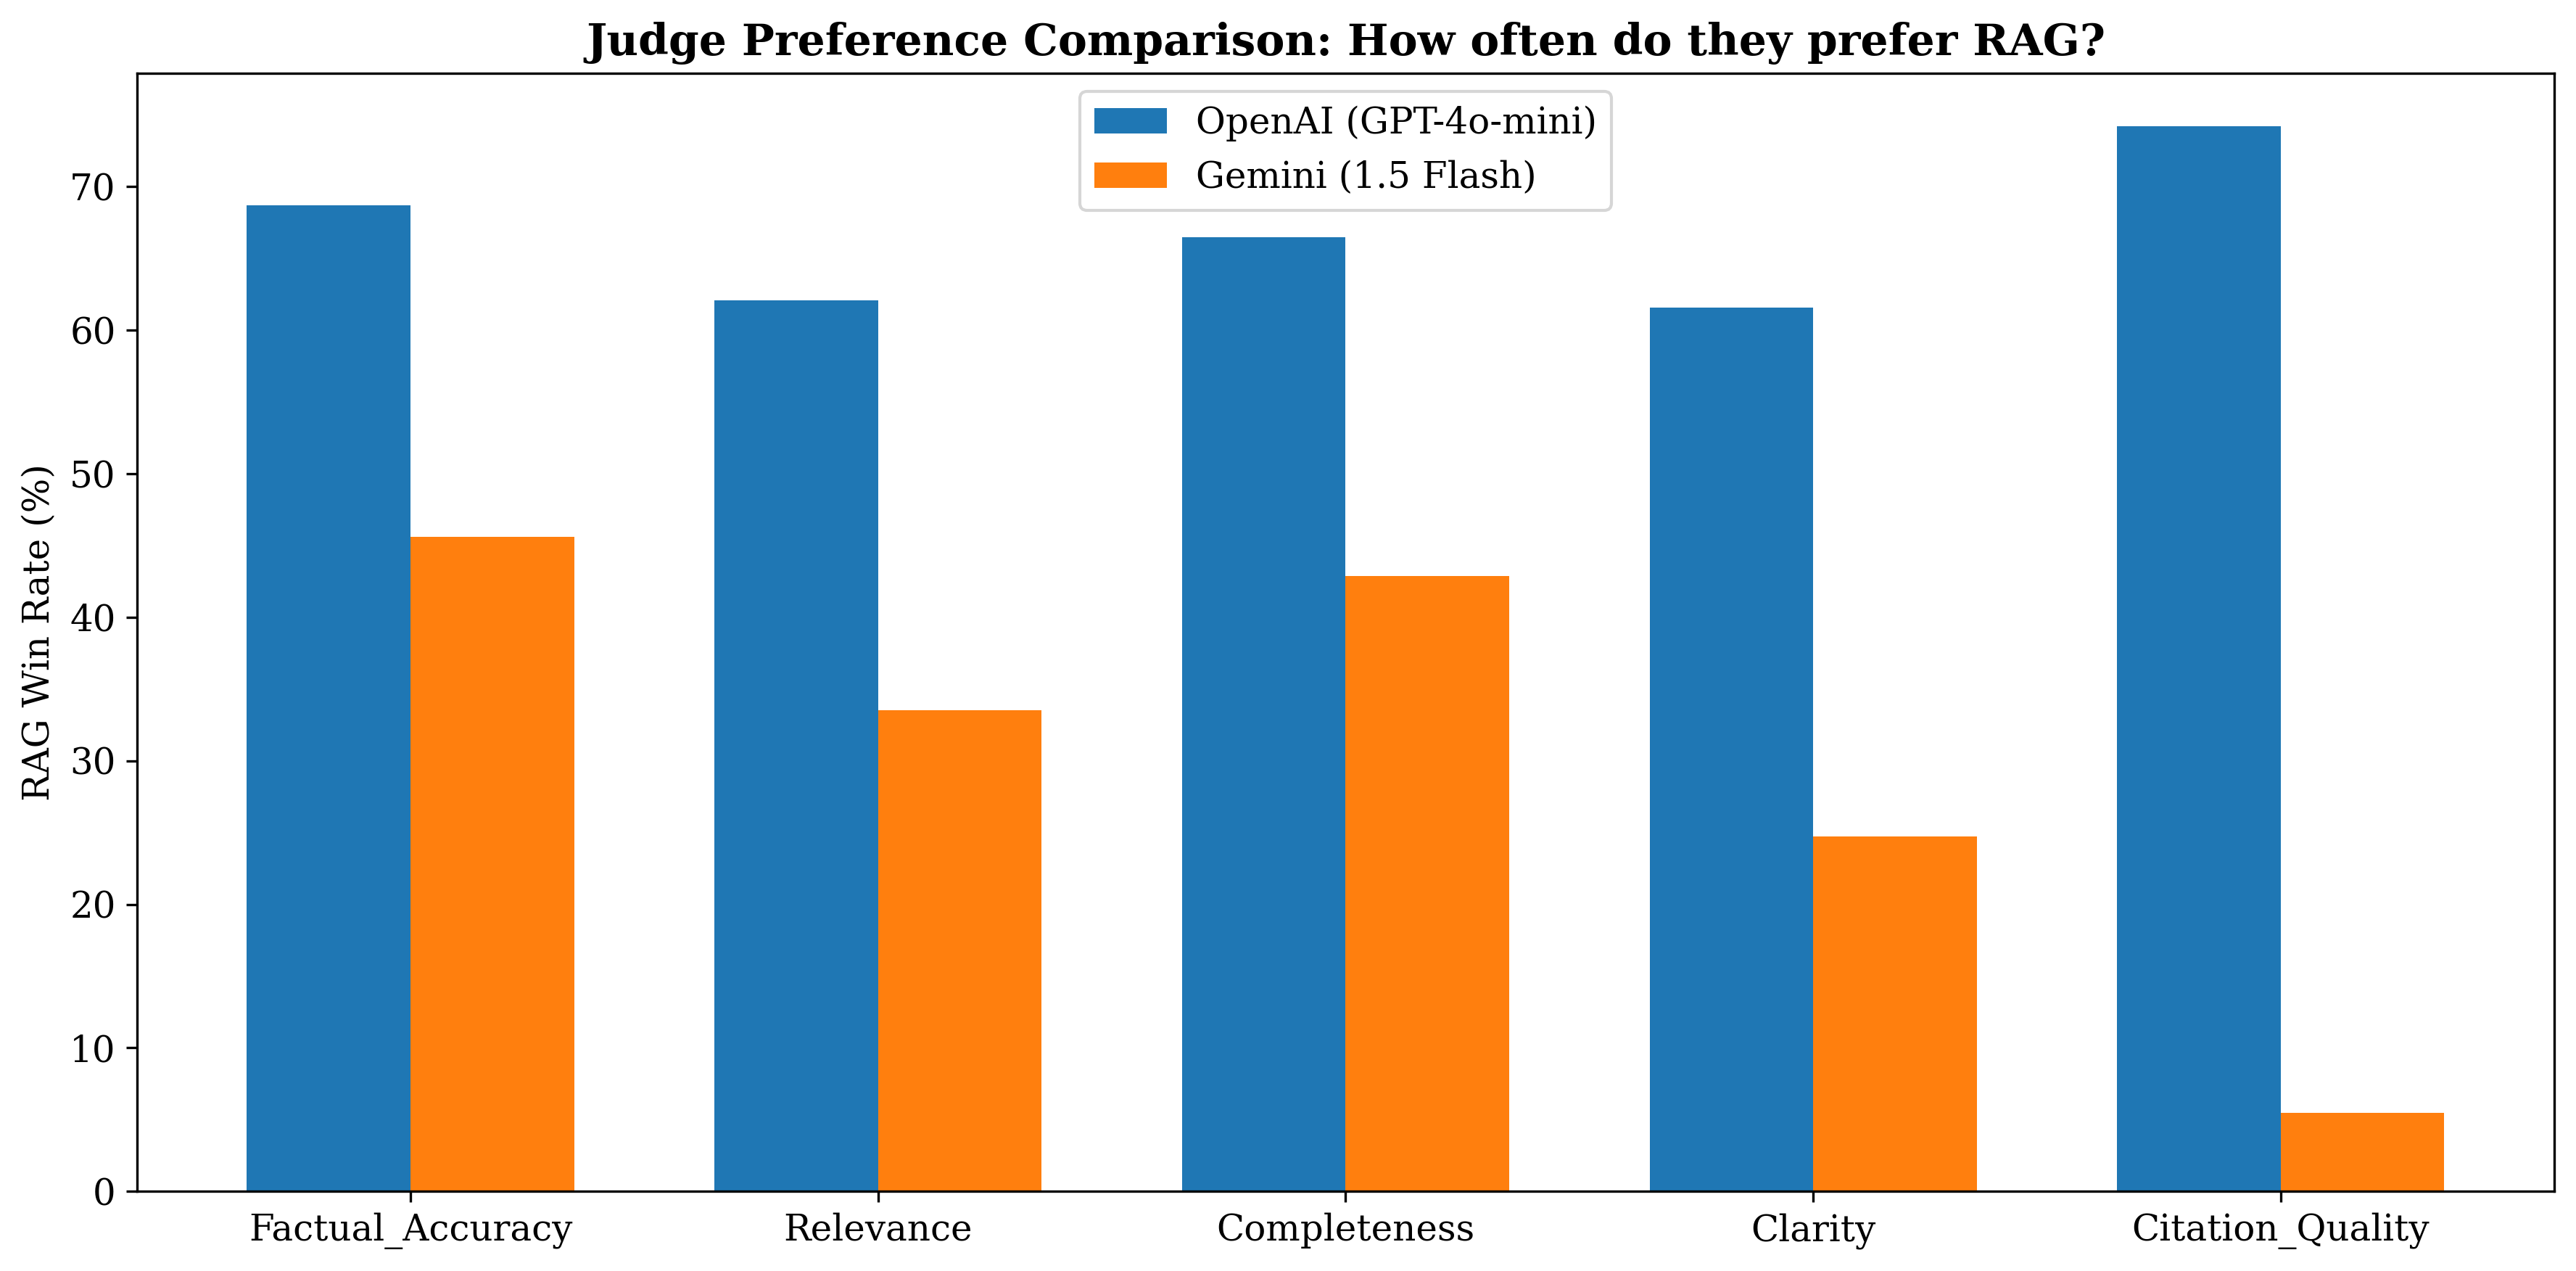

In [6]:
# =============================================================================
# ANALYSIS: JUDGE PREFERENCE PROFILES (OPENAI vs GEMINI)
# =============================================================================
# This analysis determines if the two judges have different "tastes" or biases.
# e.g., Does OpenAI prefer RAG more often than Gemini does?

judge_comparison_data = []

print("JUDGE PREFERENCE PROFILES (RAG vs AGENT)")
print("="*80)
print(f"{'Metric':<20} | {'Judge':<10} | {'RAG Win %':<10} | {'Agent Win %':<12} | {'Tie %':<10}")
print("-" * 80)

for metric in CORE_EVALUATION_DIMS:
    if 'metric_dfs' in locals() and metric in metric_dfs:
        df = metric_dfs[metric]
        
        if len(df) == 0:
            continue
            
        # Calculate preferences for each judge
        for judge, col in [('OpenAI', 'Pref_OpenAI'), ('Gemini', 'Pref_Gemini')]:
            counts = df[col].value_counts(normalize=True)
            rag_pct = counts.get('RAG', 0) * 100
            agent_pct = counts.get('Agent', 0) * 100
            tie_pct = counts.get('Tie', 0) * 100
            
            print(f"{metric:<20} | {judge:<10} | {rag_pct:<10.1f} | {agent_pct:<12.1f} | {tie_pct:<10.1f}")
            
            judge_comparison_data.append({
                'Metric': metric,
                'Judge': judge,
                'RAG_Win_Rate': rag_pct,
                'Agent_Win_Rate': agent_pct,
                'Tie_Rate': tie_pct
            })
            
        # Calculate Contradiction Rate (Direct Disagreement: RAG vs Agent)
        contradictions = df[((df['Pref_OpenAI'] == 'RAG') & (df['Pref_Gemini'] == 'Agent')) | 
                            ((df['Pref_OpenAI'] == 'Agent') & (df['Pref_Gemini'] == 'RAG'))]
        contradiction_rate = len(contradictions) / len(df) * 100
        print(f"   > Contradiction Rate (Opposite preferences): {contradiction_rate:.1f}%")
        print("-" * 80)

# Visualization of Bias
if judge_comparison_data:
    comp_df = pd.DataFrame(judge_comparison_data)
    
    # Pivot for easier comparison of RAG Win Rates
    bias_analysis = comp_df.pivot(index='Metric', columns='Judge', values='RAG_Win_Rate')
    bias_analysis['Diff (OpenAI - Gemini)'] = bias_analysis['OpenAI'] - bias_analysis['Gemini']
    
    print("\nBIAS ANALYSIS: RAG WIN RATE DIFFERENCE")
    print("Positive values indicate OpenAI favors RAG more than Gemini does.")
    display(bias_analysis.round(1))
    
    # Plotting
    try:
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(CORE_EVALUATION_DIMS))
        width = 0.35
        
        # Filter data for plotting to ensure order matches CORE_EVALUATION_DIMS
        oai_data = [comp_df[(comp_df['Metric']==m) & (comp_df['Judge']=='OpenAI')]['RAG_Win_Rate'].values[0] 
                   for m in CORE_EVALUATION_DIMS if m in comp_df['Metric'].values]
        gem_data = [comp_df[(comp_df['Metric']==m) & (comp_df['Judge']=='Gemini')]['RAG_Win_Rate'].values[0] 
                   for m in CORE_EVALUATION_DIMS if m in comp_df['Metric'].values]
        
        # Define colors
        colors = {
            'GPT-4o-mini': '#1f77b4',      # Professional blue
            'Gemini 1.5 Flash': '#ff7f0e'  # Professional orange
        }
        
        rects1 = ax.bar(x - width/2, oai_data, width, label='OpenAI (GPT-4o-mini)', color=colors['GPT-4o-mini'])
        rects2 = ax.bar(x + width/2, gem_data, width, label='Gemini (1.5 Flash)', color=colors['Gemini 1.5 Flash'])
        
        ax.set_ylabel('RAG Win Rate (%)')
        ax.set_title('Judge Preference Comparison: How often do they prefer RAG?')
        ax.set_xticks(x)
        ax.set_xticklabels([m for m in CORE_EVALUATION_DIMS if m in comp_df['Metric'].values])
        ax.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate plot: {e}")
else:
    print("No data available for judge comparison.")